# Autoencoder Convolutif Variationnel

In [1]:
import tensorflow as tf
import numpy as np
import os, sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from time import time

In [2]:
pathname = os.path.dirname(sys.argv[0])        
path = os.path.abspath(pathname)            
mnist = tf.keras.datasets.mnist
tf.reset_default_graph()

(Xtrain, Ytrain),(Xtest, Ytest) = mnist.load_data()
Xtrain, Xtest = Xtrain / 255.0, Xtest / 255.0

XtrainChannel = [np.reshape(elt, (28, 28, 1)) for elt in Xtrain]
XtestChannel  = [np.reshape(elt, (28, 28, 1)) for elt in Xtest]

dimensionCode = 10

In [3]:
def batch(X, n):
    X = np.array(X)
    np.random.shuffle(X)
    n = len(X)//n
    return np.array(np.array_split(X, n))

In [4]:
def printRes(epoch, results):
    f, a = plt.subplots(2,10,figsize=(20,4))
    for i in range(10):
        a[0][i].imshow(Xtest[i+50])
        a[1][i].imshow(np.reshape(results[epoch][i], (28, 28)))

In [5]:
def meanCost(nbEpoch, n):
    coutMean = []
    
    for _ in tqdm(range(n)):
        cout = []
        with tf.Session() as sess:
            sess.run(init)

            for epoch in (range(nbEpoch)):
                Xbatch = batch(XtrainChannel, 1024)
                for XtrainBatch in Xbatch:

                    sess.run([optimizer], feed_dict = {x: XtrainBatch})

                c = sess.run([error], feed_dict = {x: XtestChannel})
                cout.append(c)

        coutMean.append(np.array(cout))
        
    coutMean = np.array(coutMean)
    
    return np.mean(coutMean, axis = 0)

In [70]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape = [None, 28, 28, 1], name = "input")

encoderConv1 = tf.layers.conv2d(
    x,
    8,
    [5, 5],
    padding='same',
    activation=tf.nn.relu,
)

encoderPool1 = tf.layers.max_pooling2d(
        inputs = encoderConv1, 
        pool_size = [2, 2], 
        strides = 2
        )

encoderConv2 = tf.layers.conv2d(
    encoderPool1,
    16,
    [3, 3],
    padding='same',
    activation=tf.nn.relu
)

encoderPool2 = tf.layers.max_pooling2d(
        inputs = encoderConv2, 
        pool_size = [2, 2], 
        strides = 2
        )

encoderFlat = tf.reshape(encoderPool2, shape = [-1, 7 * 7 * 16])

encoderNorm = tf.layers.batch_normalization(
    encoderFlat,
    training = True
)

encoderDense = tf.layers.dense(
    encoderNorm,
    784,
    activation=tf.nn.sigmoid,
)


mean = tf.layers.dense(
    encoderDense,
    10,
    activation = tf.identity,
)


stddev = tf.layers.dense(
        inputs = encoderDense,
        units = 10,
        activation = tf.nn.softplus
        )

code = mean + stddev * (tf.random_normal(tf.shape(mean), 0, 1, dtype = tf.float32))

decoderDense = tf.layers.dense(
    code,
    784,
    activation = tf.nn.relu
)

decoderExitNorm = tf.layers.batch_normalization(
    decoderDense,
    training = True
)

decoderDense2 = tf.layers.dense(
    decoderExitNorm,
    14*14*8,
    activation = tf.nn.sigmoid,
)

decoderReshaped = tf.reshape(decoderDense2, shape = [-1, 14, 14, 8])

decoderImage1 = tf.image.resize_images(
    decoderReshaped,
    (28, 28),
    method = tf.image.ResizeMethod.BILINEAR
)


decoderDeconv1 = tf.layers.conv2d(
    decoderImage1,
    filters = 4,
    kernel_size = 3,
    strides = 1,
    padding='same',
    activation = tf.nn.relu
)

decoderPool1 = tf.layers.max_pooling2d(
        inputs = decoderDeconv1, 
        pool_size = [2, 2], 
        strides = 2
        )

decoderImage2 = tf.image.resize_images(
    decoderPool1,
    (56, 56),
    method = tf.image.ResizeMethod.BILINEAR
)


decoderDeconv2 = tf.layers.conv2d(
    decoderImage2,
    filters = 1,
    kernel_size = 3,
    strides = 1,
    padding='same',
    activation = tf.nn.relu
)

decoderPool2 = tf.layers.max_pooling2d(
        inputs = decoderDeconv2, 
        pool_size = [2, 2], 
        strides = 2
        )

decoderFlat = tf.reshape(decoderPool2, shape = [-1, 28*28])

decoderNorm = tf.layers.batch_normalization(
    decoderFlat,
    training = True
)

decoderDenseExit = tf.layers.dense(
    decoderNorm,
    28*28,
    activation = tf.nn.sigmoid
)

y = tf.reshape(decoderDenseExit, shape = [-1, 28, 28, 1])

In [71]:
error = tf.losses.mean_squared_error(y, x)
train_ops = tf.train.AdamOptimizer(learning_rate = 0.01).minimize(error)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
optimizer = tf.group([train_ops, update_ops])

In [72]:
decoderPool2.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [73]:
init = tf.global_variables_initializer()
nbEpoch = 5
results, cout = [], []
saver = tf.train.Saver(tf.global_variables())

In [74]:
def training(nbEpoch):
    cout = []
    with tf.Session() as sess:
        sess.run(init)


        for epoch in tqdm(range(nbEpoch)):
            Xbatch = batch(XtrainChannel, 1024)
            for XtrainBatch in Xbatch:

                sess.run([optimizer], feed_dict = {x: XtrainBatch})

            c = sess.run([error], feed_dict = {x: XtestChannel})
            cout.append(c)
            results.append(y.eval(feed_dict = {x: XtestChannel[50:60]})) 
    return results, cout

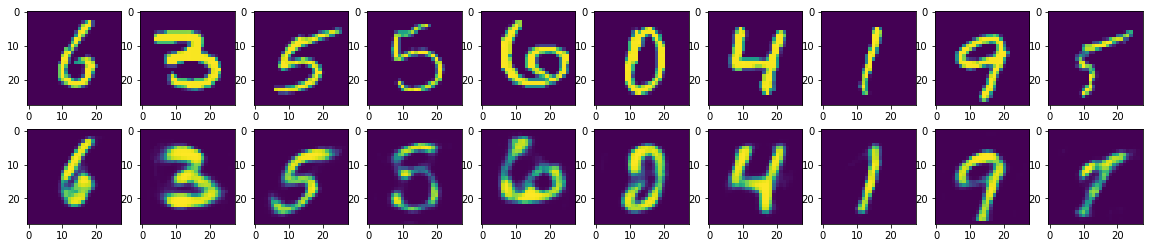

In [77]:
printRes(29, resultsSigmo[0])

# Double Déconv

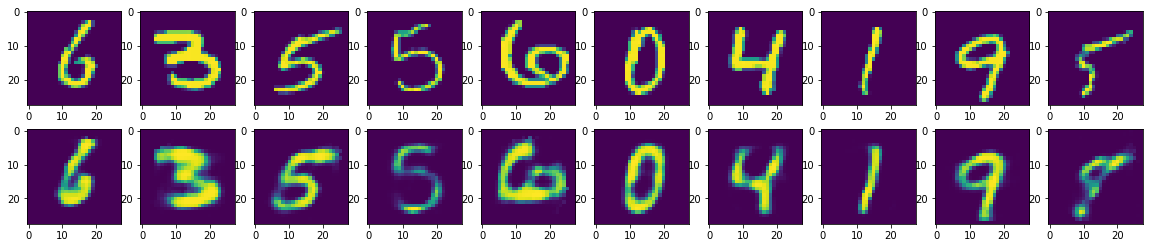

In [69]:
printRes(9, resultsSigmo[0])

# Resize + Conv

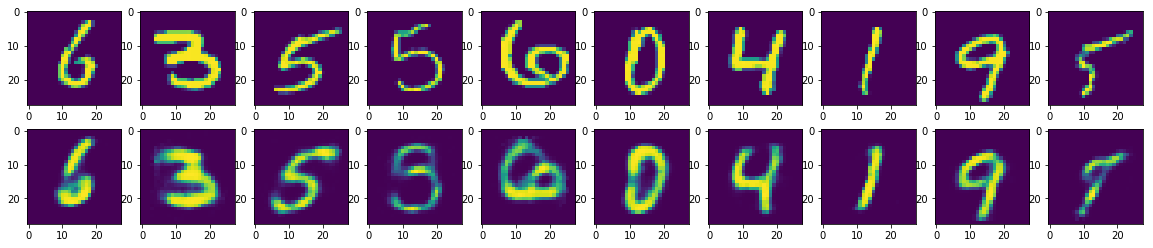

In [32]:
printRes(9, resultsSigmo[0])

# Deux couches de convolutions

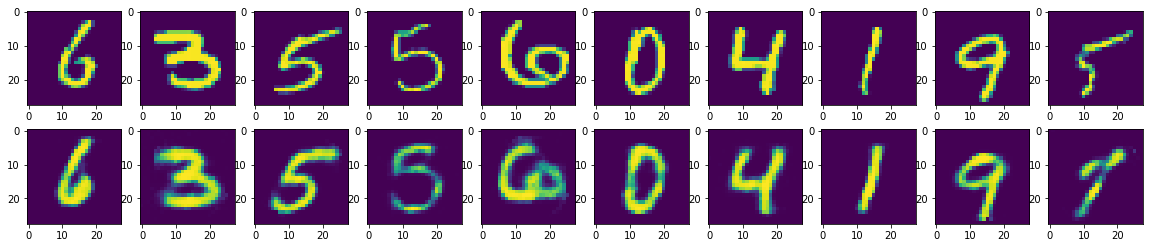

In [16]:
printRes(9, resultsSigmo[0])

# Classique Sigmoïde

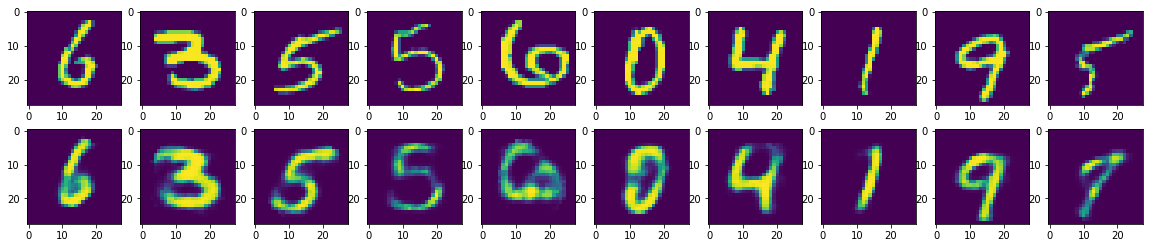

In [22]:
printRes(9, resultsSigmo)

In [10]:
resultsClassique = training(10)

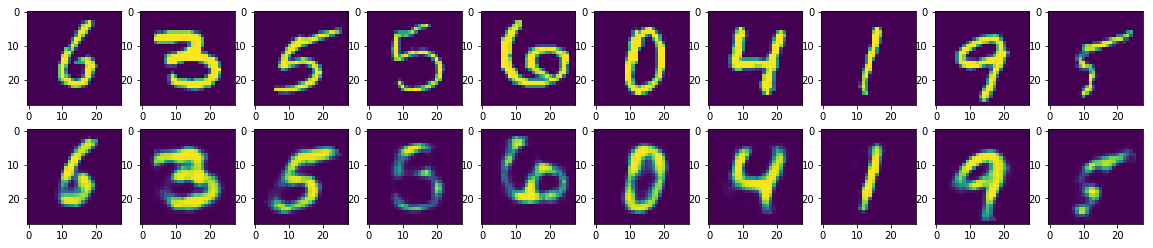

In [11]:
printRes(9, resultsClassique)

In [16]:
modeleSigmo = meanCost(10, 10)

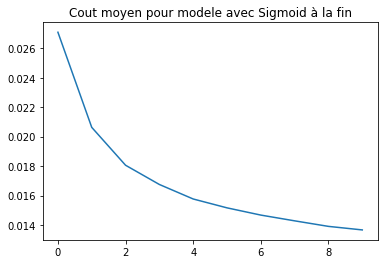

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(range(10), modeleClassique)
plt.title("Cout moyen pour modele avec Sigmoid à la fin")
plt.show()
plt.savefig("modeleclassique.jpeg")

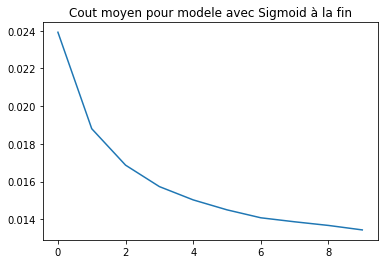

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(range(10), modeleSigmo)
plt.title("Cout moyen pour modele avec Sigmoid à la fin")
plt.show()
plt.savefig("modelesigmo.jpeg")

In [12]:
modeleClassique = meanCost(10, 20)

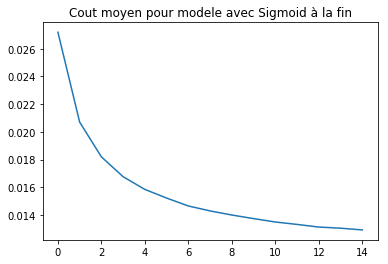

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(range(15), modeleClassique)
plt.title("Cout moyen pour modele avec Sigmoid à la fin")
plt.show()
plt.savefig("modeleclassique20.jpeg")

In [16]:
modeleClassique[-1]

array([0.01293061], dtype=float32)

In [20]:
modeleSigmo = meanCost(10, 20)

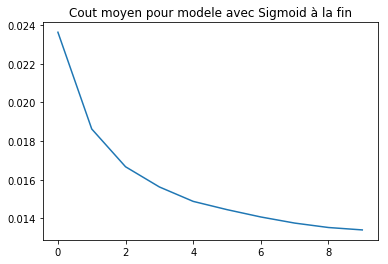

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(range(10), modeleSigmo)
plt.title("Cout moyen pour modele avec Sigmoid à la fin")
plt.show()
plt.savefig("modelesigmo20.jpeg")

In [23]:
modeleSigmo[-1]

array([0.01340118], dtype=float32)

In [25]:
c = training(15)[1]

[0.012991277]